# Variational Autoencoders

In [1]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/tmp/data/MNIST_data')

Extracting /tmp/data/MNIST_data/train-images-idx3-ubyte.gz
Extracting /tmp/data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
tf.reset_default_graph()

batch_size = 64

X_in = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='X')
Y    = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='Y')
Y_flat = tf.reshape(Y, shape=[-1, 28 * 28])
keep_prob = tf.placeholder(dtype=tf.float32, shape=(), name='keep_prob')

dec_in_channels = 1
n_latent = 8

reshaped_dim = [-1, 7, 7, dec_in_channels]
inputs_decoder = 49 * dec_in_channels // 2
print(inputs_decoder)

24


In [4]:
def lrelu(x, alpha=0.3):
    return tf.maximum(x, tf.multiply(x, alpha))

###  Defining the encoder
What's most noteworthy is the fact that we are creating two vectors in our encoder, as the encoder is supposed to create objects following a Gaussian Distribution:
* A vector of means
* A vector of standard deviations

You will see later how we "force" the encoder to make sure it really creates values following a Normal Distribution. The returned values that will be fed to the decoder are the z-values. We will need the mean and standard deviation of our distributions later, when computing losses.

In [5]:
def encoder(X_in, keep_prob):
    activation = lrelu
    with tf.variable_scope("encoder", reuse=None):
        X = tf.reshape(X_in, shape=[-1, 28, 28, 1])
        x = tf.layers.conv2d(X, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=1, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.contrib.layers.flatten(x)
        mn = tf.layers.dense(x, units=n_latent)
        sd = 0.5 * tf.layers.dense(x, units=n_latent)            
        epsilon = tf.random_normal(tf.stack([tf.shape(x)[0], n_latent])) 
        z  = mn + tf.multiply(epsilon, tf.exp(sd))
        
        return z, mn, sd

### Defining the decoder
The decoder **does not** care about whether the input values are sampled from some specific distribution that has been defined by us. It simply will try to reconstruct the input images. To this end, we use a series of transpose convolutions.

In [6]:
def decoder(sampled_z, keep_prob):
    with tf.variable_scope("decoder", reuse=None):
        x = tf.layers.dense(sampled_z, units=inputs_decoder, activation=lrelu)
        #x = tf.layers.dense(sampled_z, inputs_decoder, activation=lrelu)
        x = tf.layers.dense(x, units=inputs_decoder * 2 + 1, activation=lrelu)
        x = tf.reshape(x, reshaped_dim)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=28*28, activation=tf.nn.sigmoid)
        img = tf.reshape(x, shape=[-1, 28, 28])
        return img

Now, we'll wire together both parts:

In [7]:
sampled, mn, sd = encoder(X_in, keep_prob)

In [8]:
dec = decoder(sampled, keep_prob)

### Computing losses and enforcing a Gaussian latent distribution
For computing the image reconstruction loss, we simply use squared difference (which could lead to images sometimes looking a bit fuzzy). This loss is combined with the Kullback-Leibler divergence, which makes sure our latent values will be sampled from a normal distribution. For more on this topic, please take a look a Jaan Altosaar's great article on VAEs.

In [9]:
unreshaped = tf.reshape(dec, [-1, 28*28])
img_loss = tf.reduce_sum(tf.squared_difference(unreshaped, Y_flat), 1)
latent_loss = -0.5 * tf.reduce_sum(1.0 + 2.0 * sd - tf.square(mn) - tf.exp(2.0 * sd), 1)
loss = tf.reduce_mean(img_loss + latent_loss)
optimizer = tf.train.AdamOptimizer(0.0005).minimize(loss)


In [10]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

### Training the network

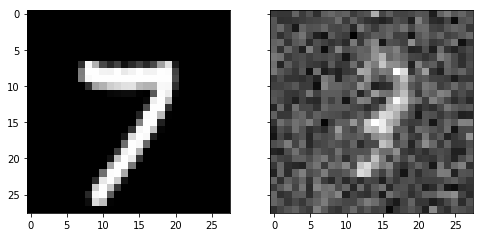

0 177.02867 177.02567 0.0030041388


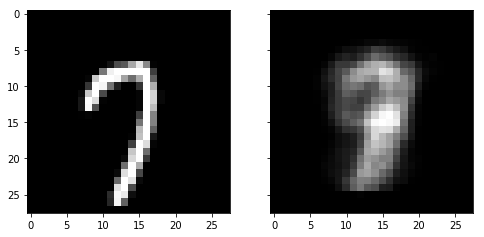

200 49.598145 47.53486 2.063283


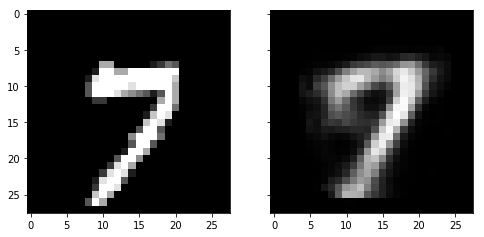

400 38.369827 31.719429 6.6503997


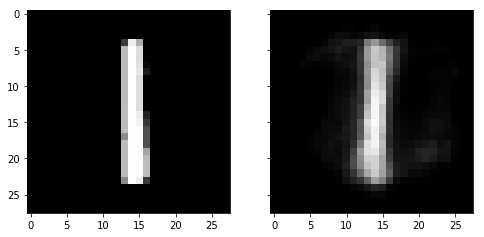

600 34.90827 27.414757 7.493514


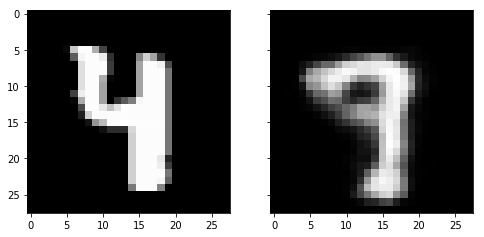

800 35.26605 27.381691 7.884356


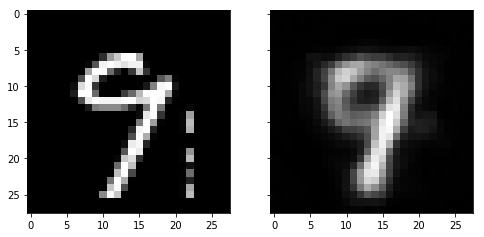

1000 31.525547 23.362522 8.163025


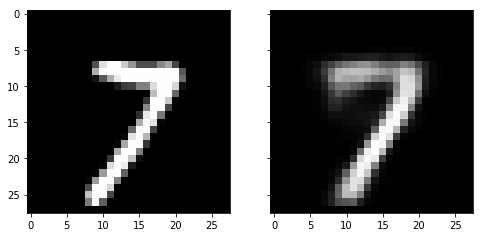

1200 31.25182 22.380207 8.871613


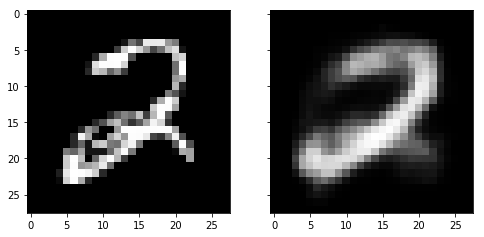

1400 33.340275 24.406235 8.93404


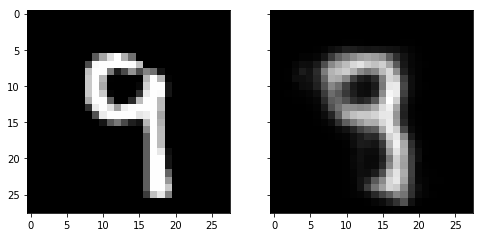

1600 33.42857 24.383135 9.045433


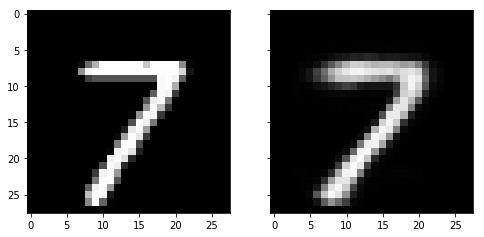

1800 31.648397 22.141388 9.507008


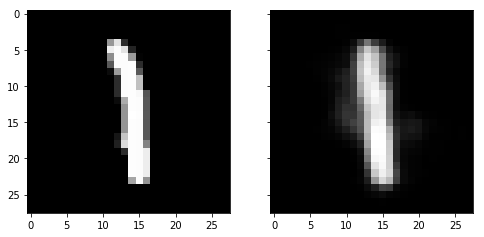

2000 30.383251 20.817226 9.566026


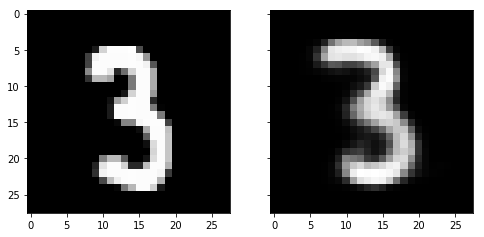

2200 29.000118 19.678429 9.321689


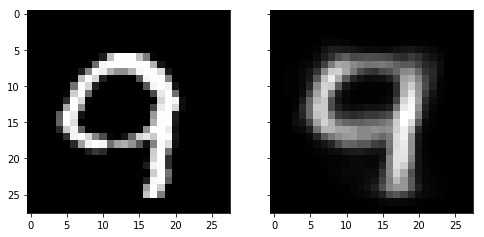

2400 32.857685 23.283325 9.574362


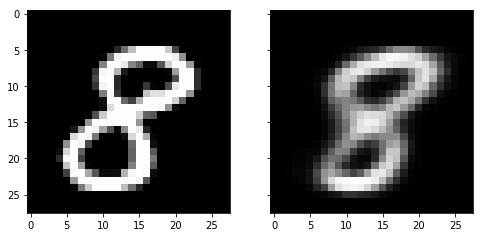

2600 31.090776 21.308975 9.7818


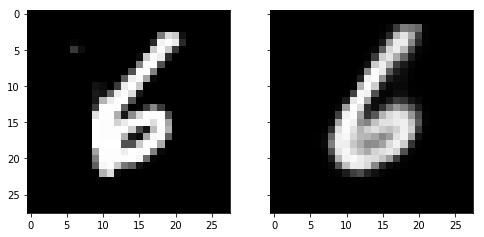

2800 28.1926 19.200233 8.992366


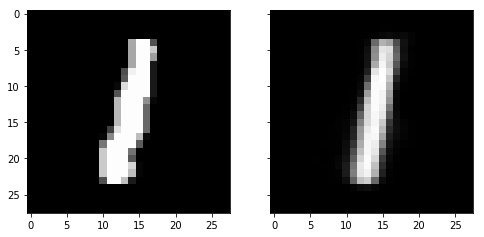

3000 31.937506 22.497606 9.439901


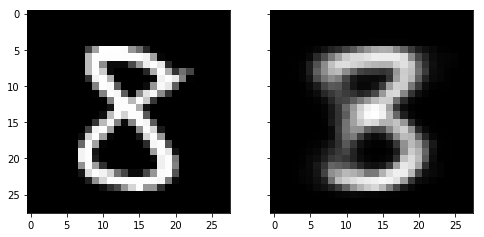

3200 30.268623 20.962164 9.306459


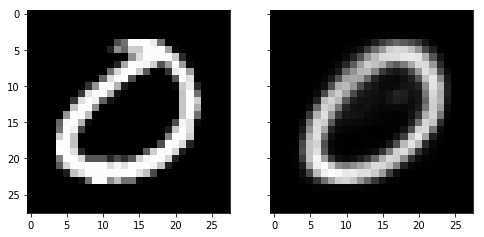

3400 30.534344 20.869125 9.66522


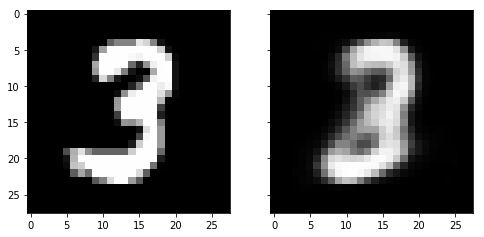

3600 29.633972 19.973034 9.660938


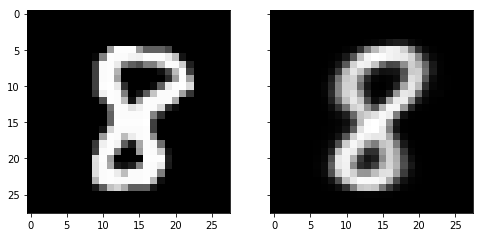

3800 31.687952 21.133415 10.554536


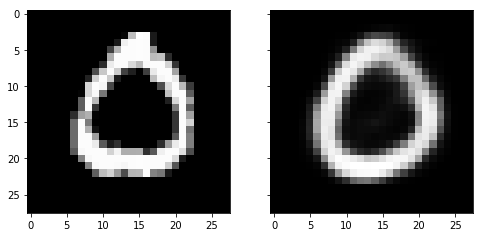

4000 29.163662 19.247719 9.915943


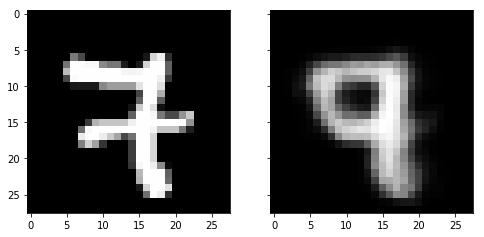

4200 30.687717 20.468899 10.218819


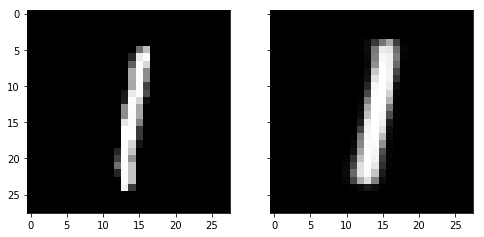

4400 28.642975 18.830769 9.812207


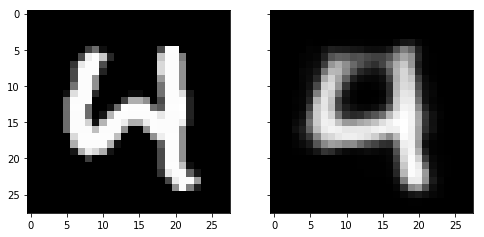

4600 31.125835 21.037428 10.088406


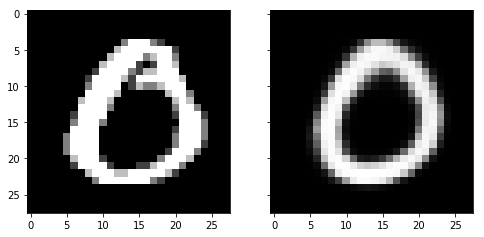

4800 27.880531 18.07946 9.801071


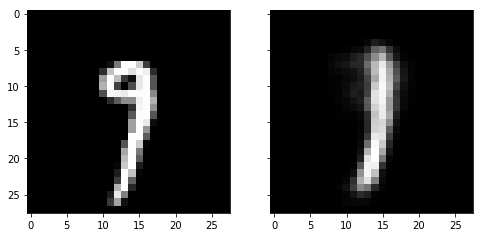

5000 28.952435 18.514065 10.43837


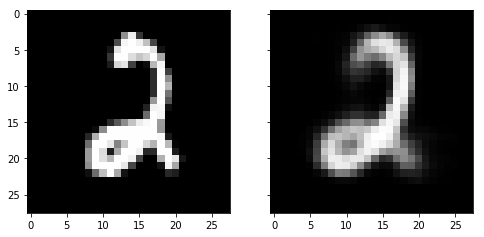

5200 27.88477 17.82068 10.064088


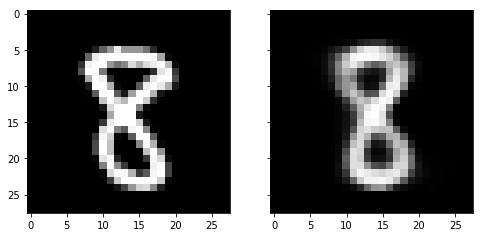

5400 29.143211 18.62347 10.519742


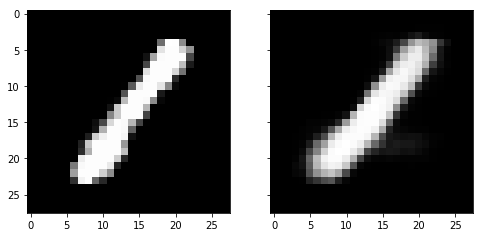

5600 26.659668 17.033333 9.626333


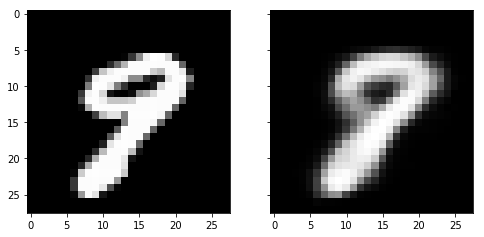

5800 29.430504 19.317562 10.112941


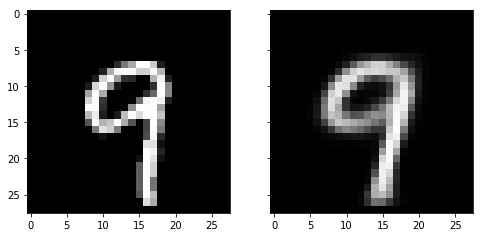

6000 26.4355 15.987776 10.447723


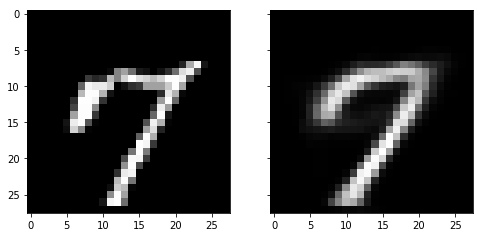

6200 28.963638 18.979244 9.984395


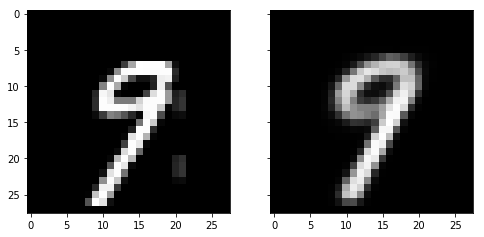

6400 28.052052 17.839241 10.21281


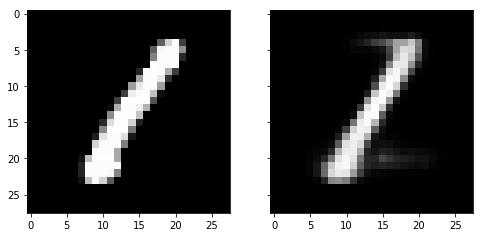

6600 30.76498 20.252728 10.512252


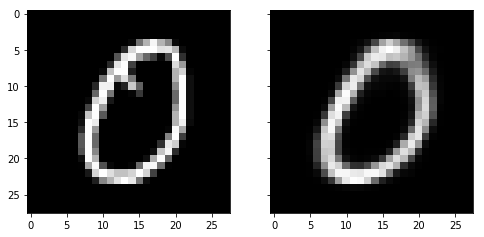

6800 28.196323 18.02002 10.176307


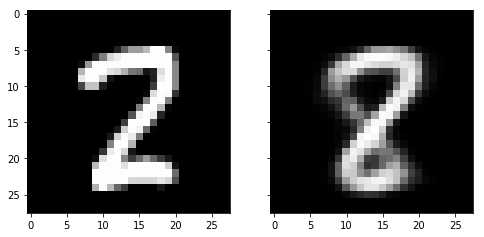

7000 28.464737 18.384365 10.08037


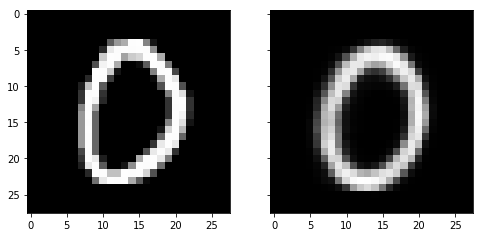

7200 29.01477 18.415354 10.599415


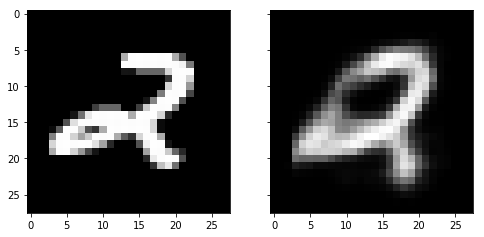

7400 29.656101 19.56228 10.09382


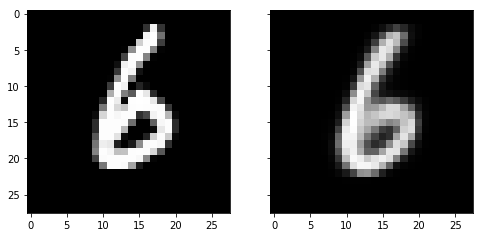

7600 29.991674 19.571985 10.419687


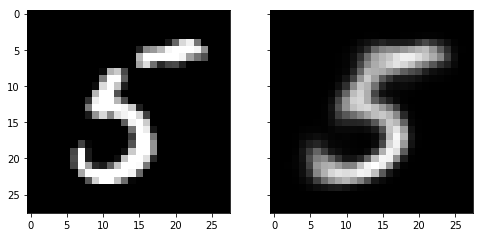

7800 30.403553 19.478683 10.92487


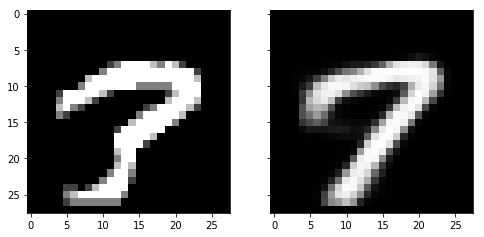

8000 29.223808 18.626331 10.597479


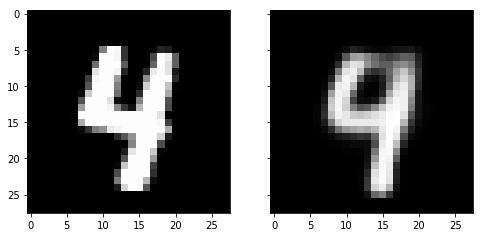

8200 27.347757 17.69928 9.648479


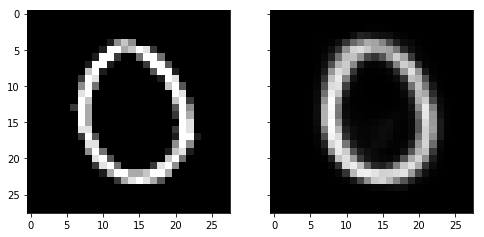

8400 28.629463 18.504604 10.124859


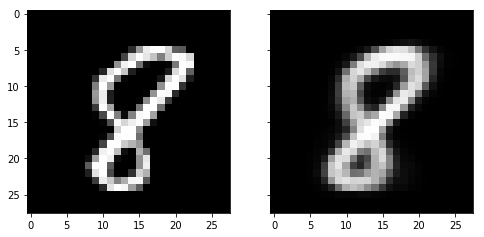

8600 29.964657 19.638103 10.326553


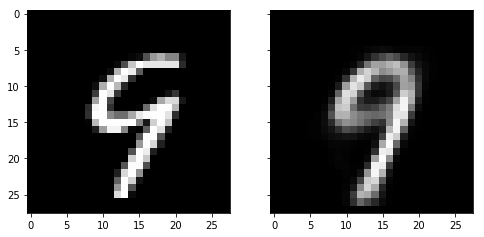

8800 30.662685 20.230282 10.432405


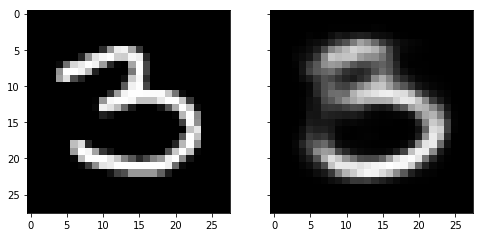

9000 30.689354 19.93596 10.753392


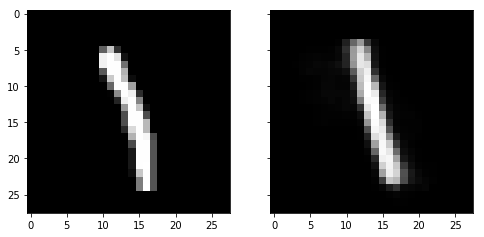

9200 28.511868 17.878746 10.633121


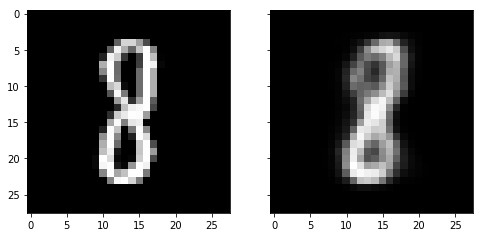

9400 29.0672 18.85866 10.208541


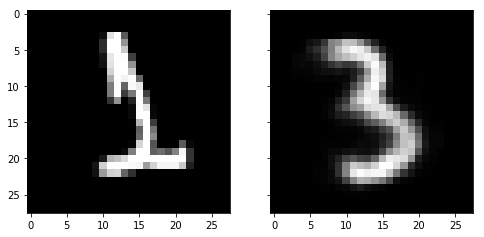

9600 28.916182 18.786787 10.1293955


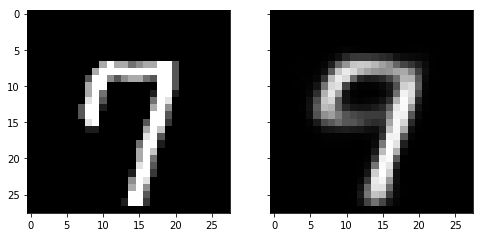

9800 28.440548 18.13434 10.306208


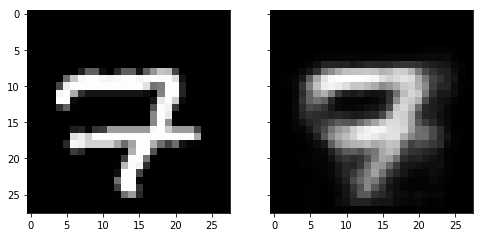

10000 28.821869 18.07408 10.74779


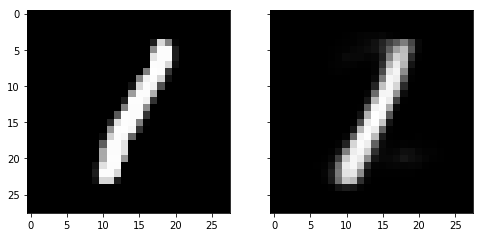

10200 26.39928 15.777665 10.621616


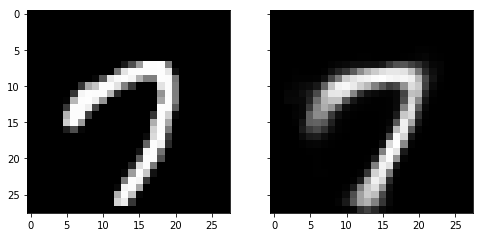

10400 29.988194 19.296257 10.691938


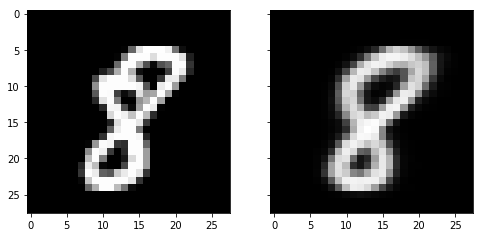

10600 26.877766 16.335863 10.541903


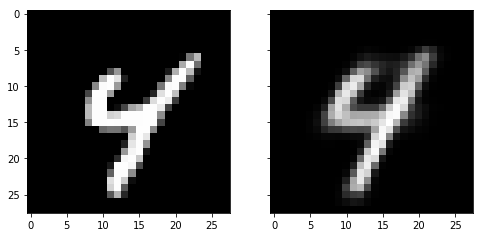

10800 29.858904 19.31619 10.542714


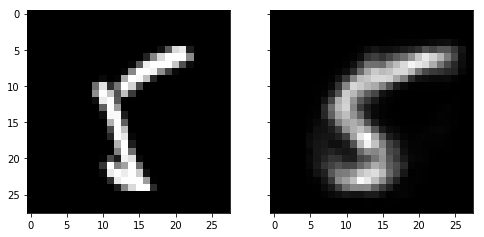

11000 29.445244 18.929676 10.515568


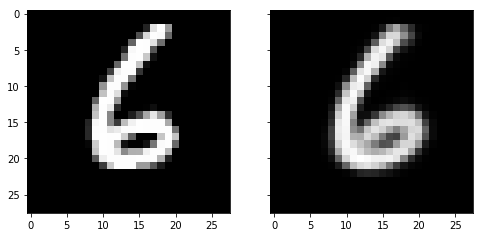

11200 26.045322 15.4888735 10.556448


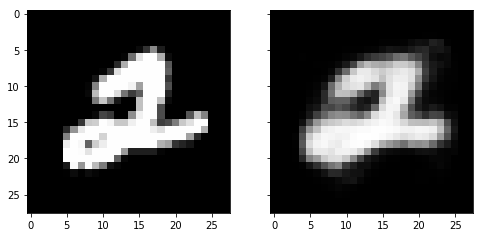

11400 25.17003 14.9128 10.257231


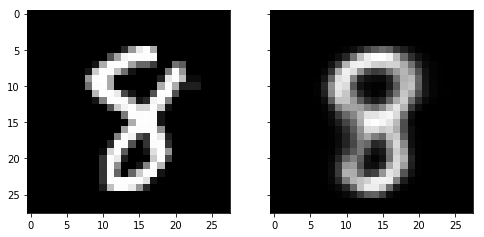

11600 29.16109 17.916409 11.244682


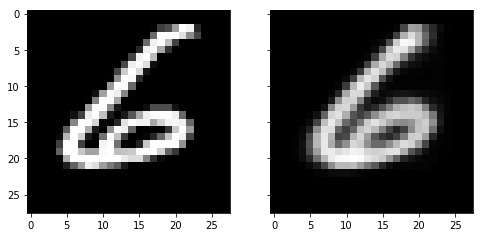

11800 27.75476 16.94218 10.812582


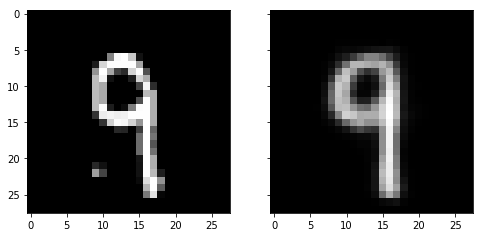

12000 28.402452 18.285606 10.116846


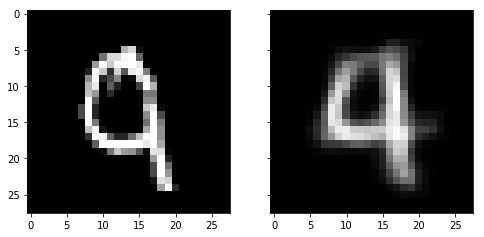

12200 28.611238 18.292702 10.318537


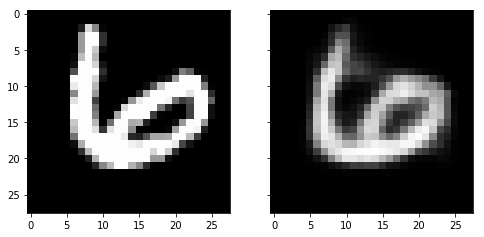

12400 29.372505 18.704191 10.668313


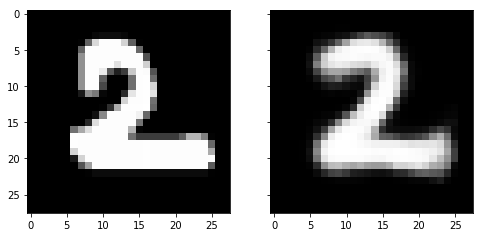

12600 28.52218 17.82581 10.696373


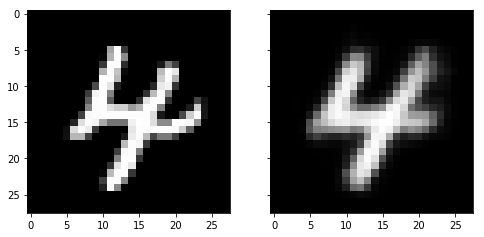

12800 28.023403 17.496155 10.527249


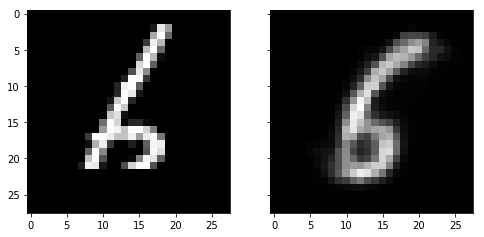

13000 29.242088 18.530499 10.71159


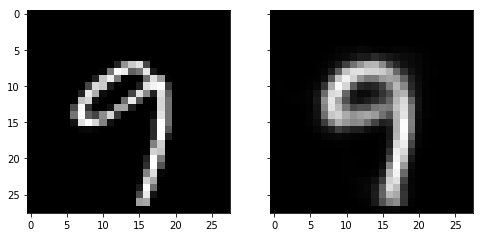

13200 27.363922 16.384789 10.979134


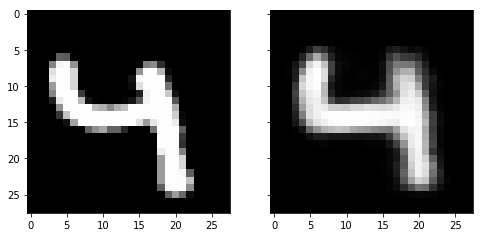

13400 26.38689 15.836221 10.55067


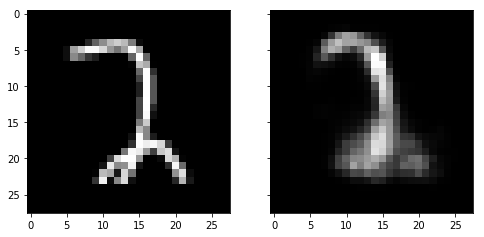

13600 30.175179 19.783241 10.391937


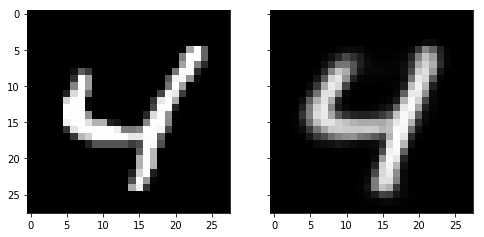

13800 25.815794 15.312839 10.502956


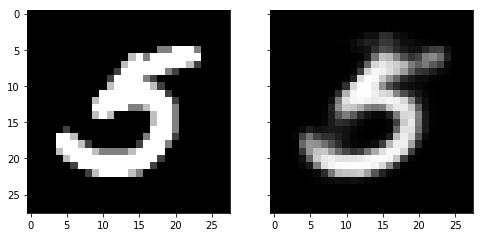

14000 29.171146 18.520142 10.651003


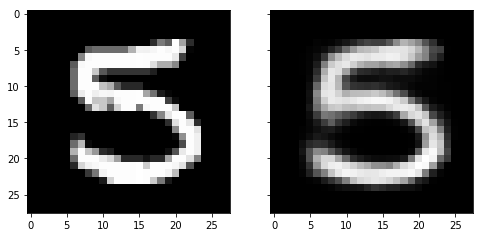

14200 27.55167 16.016935 11.534733


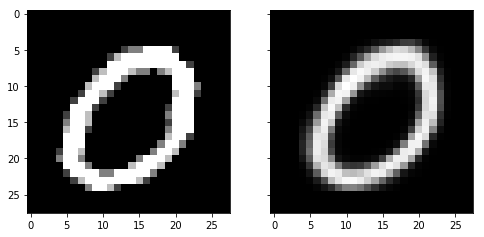

14400 28.617714 17.50598 11.111734


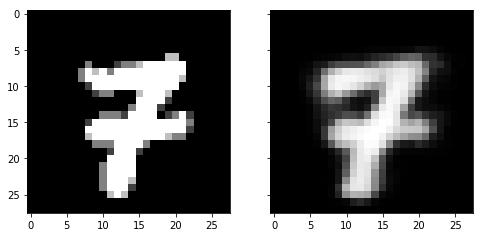

14600 28.400318 17.85736 10.542957


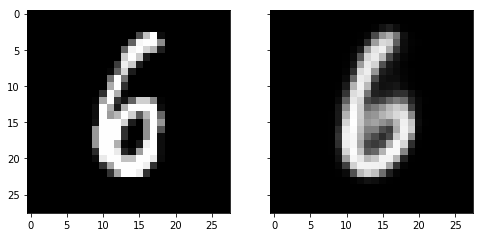

14800 25.785427 15.291374 10.494053


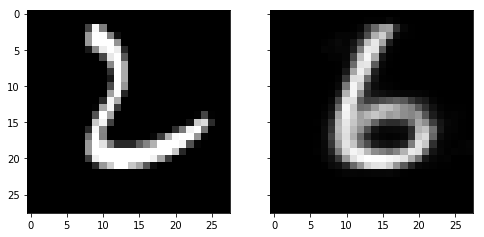

15000 26.835962 16.211311 10.624653


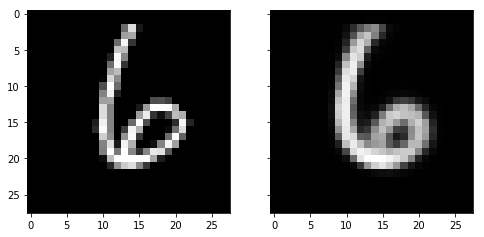

15200 26.803417 17.03888 9.764539


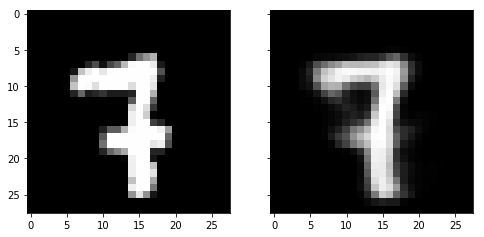

15400 26.827625 16.083755 10.743868


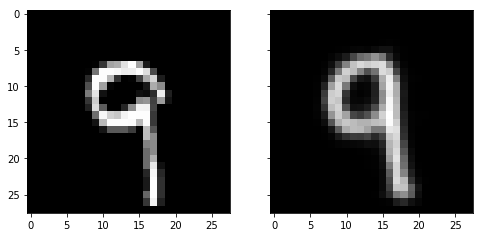

15600 29.521381 18.028214 11.493168


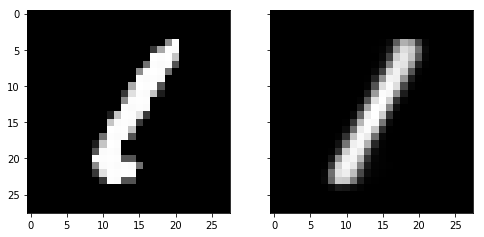

15800 26.496853 16.178282 10.318571


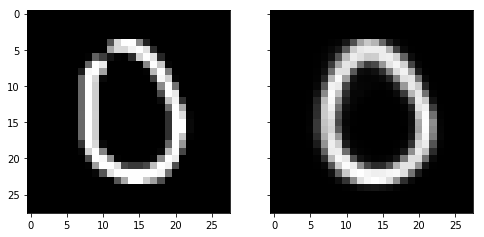

16000 28.599792 17.67767 10.922122


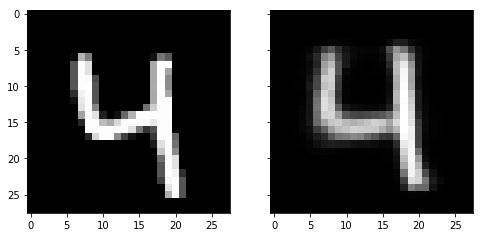

16200 26.330154 15.916523 10.413631


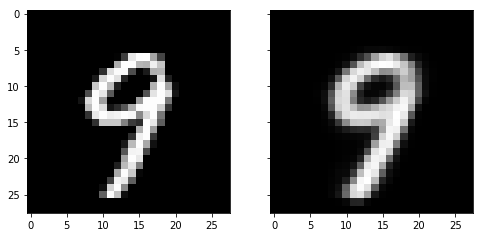

16400 27.561384 16.532063 11.02932


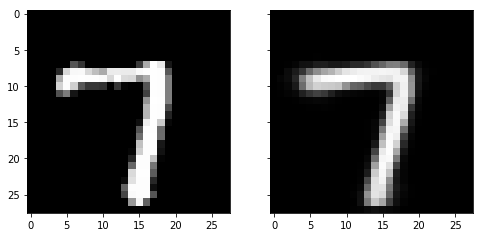

16600 26.462917 15.715757 10.747159


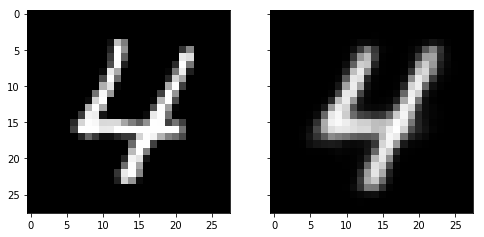

16800 28.439365 17.485485 10.95388


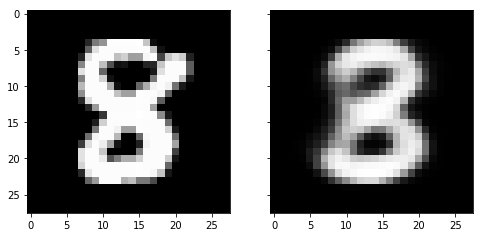

17000 28.15486 17.605764 10.549094


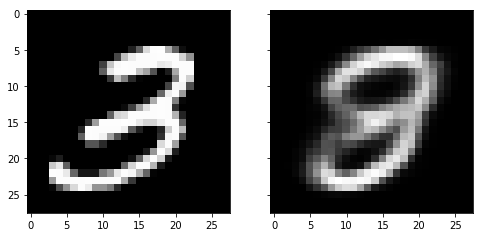

17200 30.324919 18.702793 11.622128


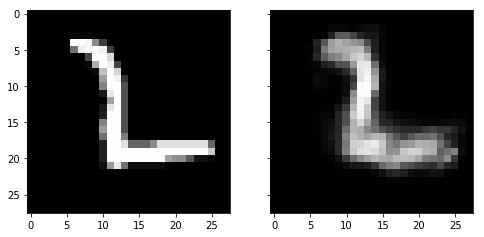

17400 27.409117 16.360159 11.048957


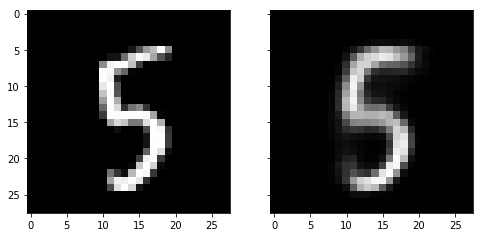

17600 28.85735 18.193756 10.663593


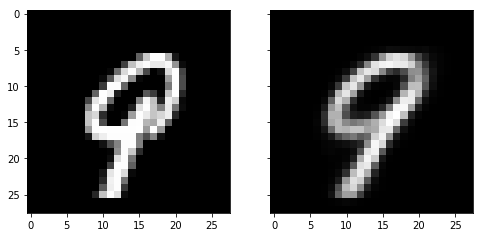

17800 27.607037 17.001717 10.605323


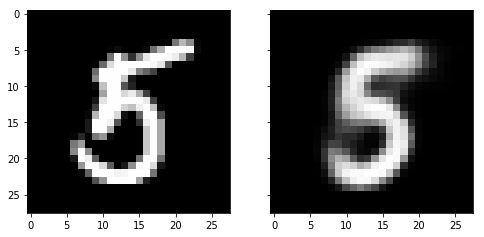

18000 26.853474 16.200954 10.652519


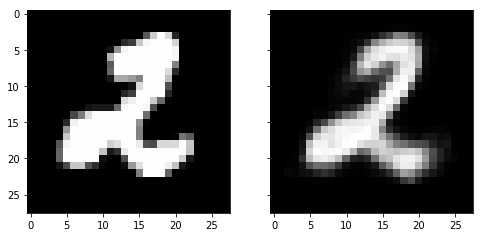

18200 27.339045 16.306099 11.032947


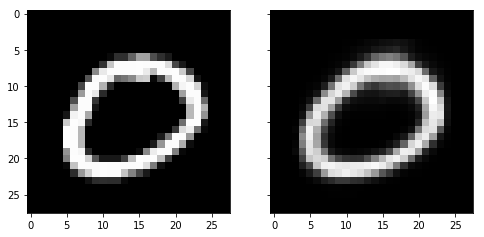

18400 28.414501 17.459515 10.954988


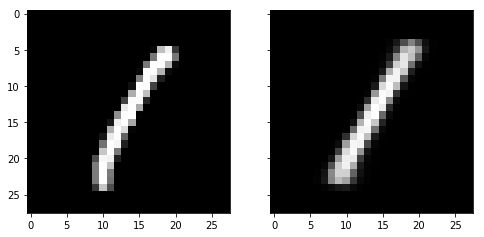

18600 28.133934 17.20615 10.927784


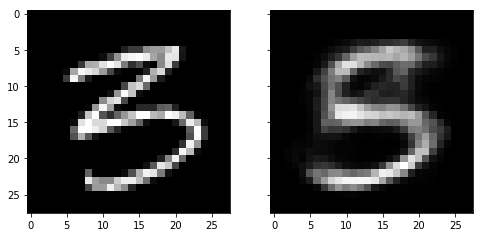

18800 26.557364 16.218327 10.339038


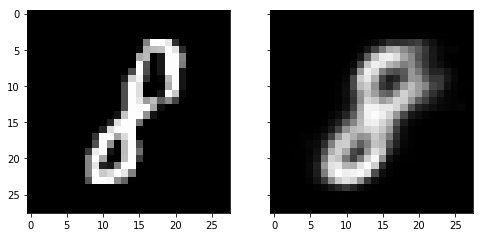

19000 27.19439 16.45515 10.73924


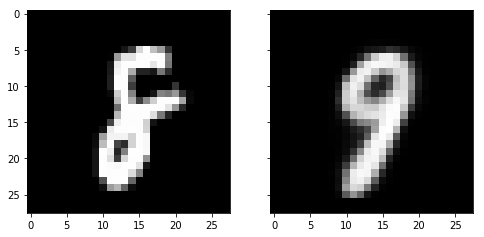

19200 29.783405 19.018648 10.764757


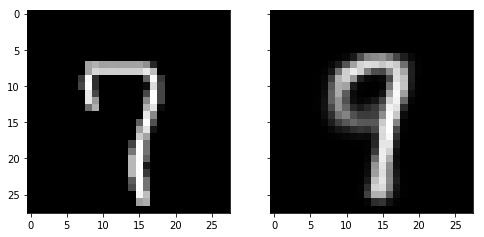

19400 28.133127 17.643085 10.49004


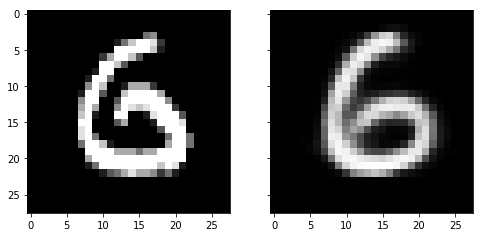

19600 26.327814 15.77088 10.556934


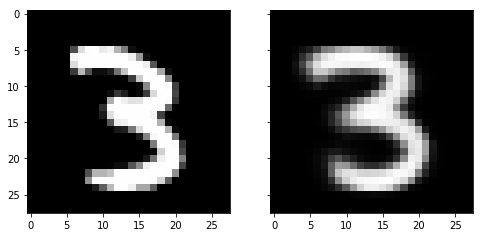

19800 28.178652 17.171638 11.007012


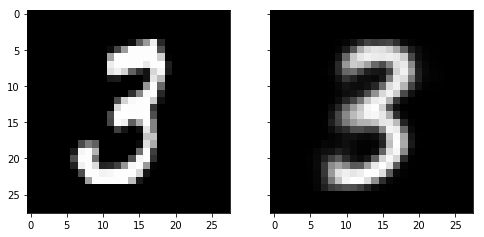

20000 28.447239 17.277744 11.169494


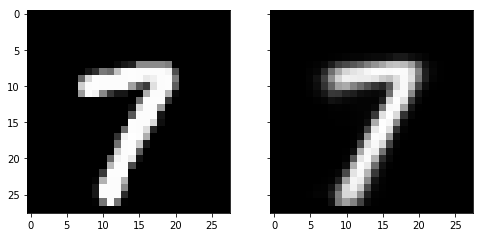

20200 27.854408 16.868969 10.985438


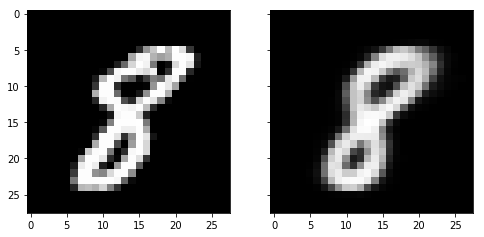

20400 28.177505 17.045605 11.131898


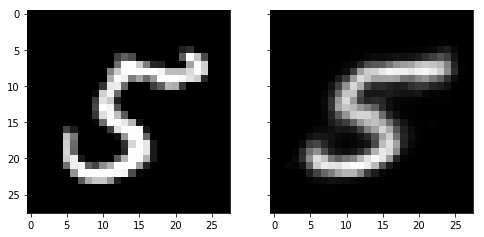

20600 27.694387 17.229198 10.465191


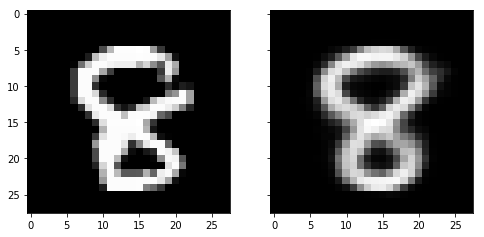

20800 25.99897 15.168471 10.8305


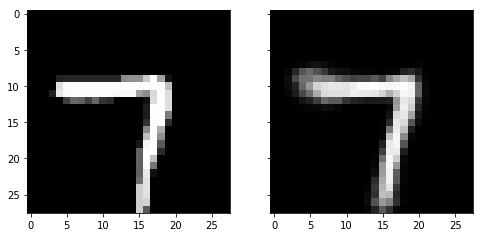

21000 27.0439 16.582047 10.461853


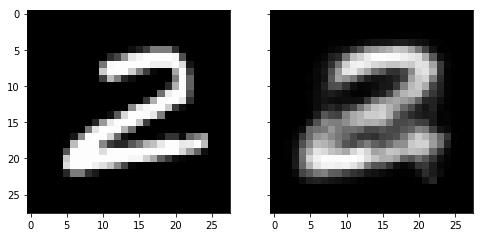

21200 28.030098 16.846565 11.183532


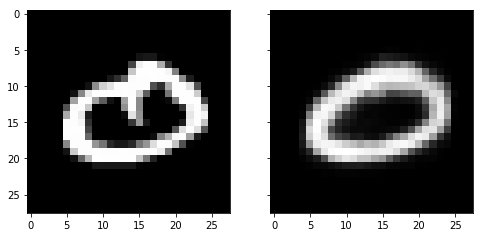

21400 26.388077 15.819197 10.568878


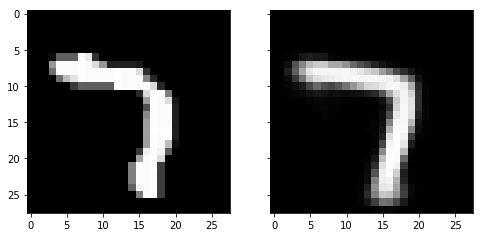

21600 26.026623 15.379277 10.647345


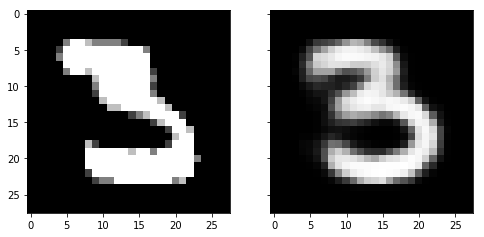

21800 27.19934 16.64455 10.554789


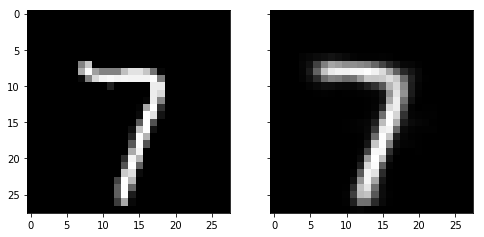

22000 25.565323 15.121498 10.443827


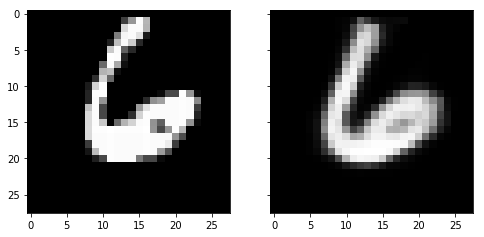

22200 26.79892 15.314187 11.484734


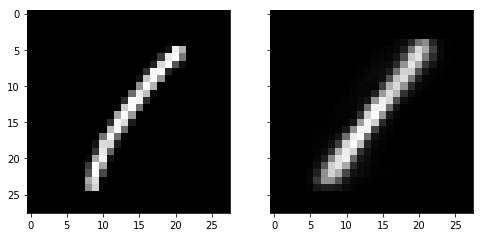

22400 25.416622 14.528204 10.888418


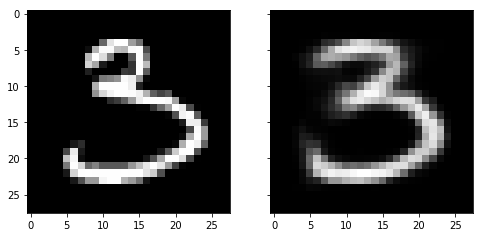

22600 29.361656 17.658018 11.703639


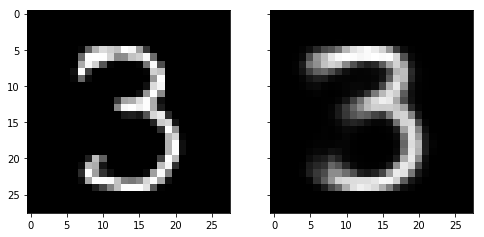

22800 27.919352 16.929255 10.990097


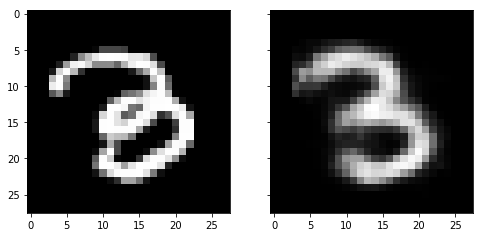

23000 28.233479 17.491041 10.742437


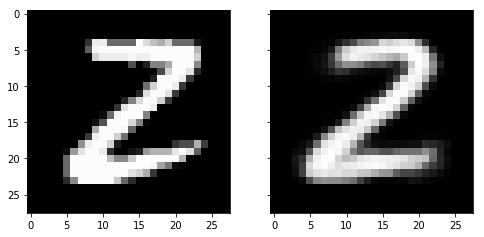

23200 26.682714 16.110703 10.572012


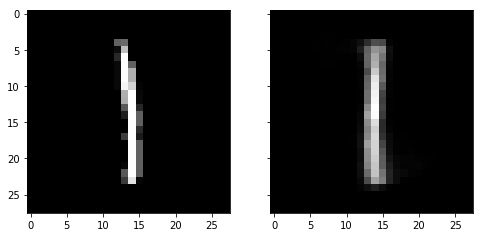

23400 27.522058 16.57284 10.94922


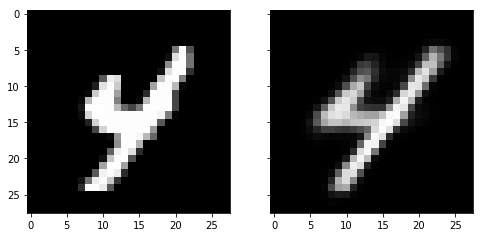

23600 28.36038 17.545895 10.814486


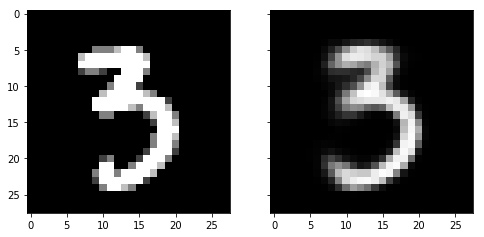

23800 27.421974 16.229301 11.192674


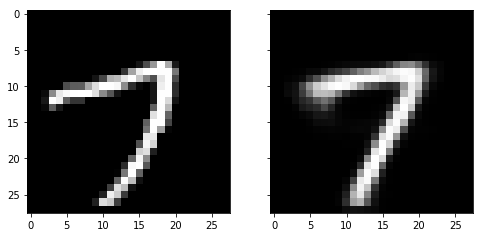

24000 29.681852 18.720016 10.961836


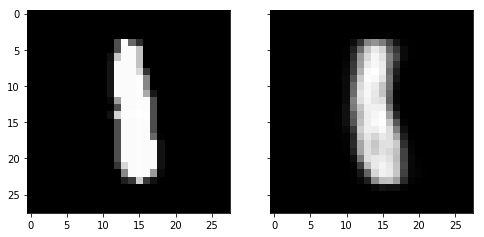

24200 27.015055 15.67056 11.344495


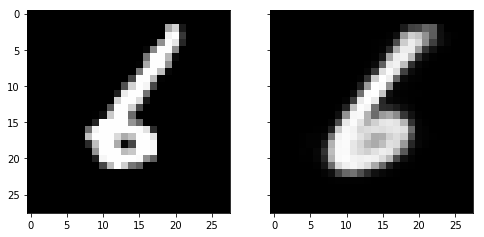

24400 24.721338 14.216974 10.504364


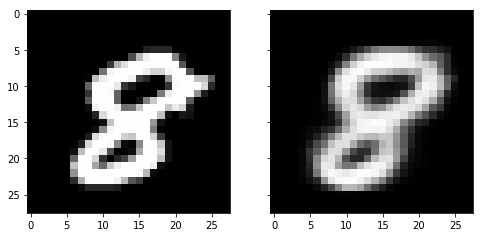

24600 27.987072 16.885986 11.101087


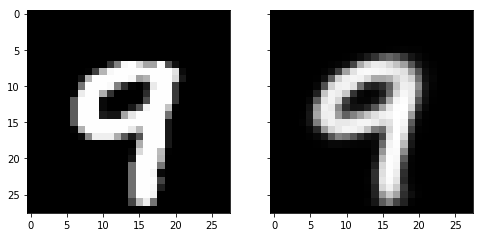

24800 26.24234 15.316046 10.926294


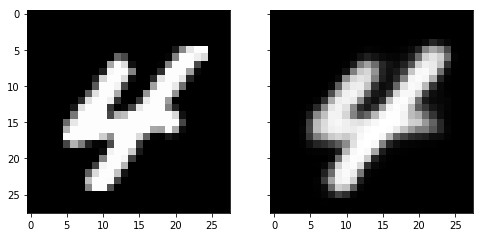

25000 28.326725 16.936308 11.390418


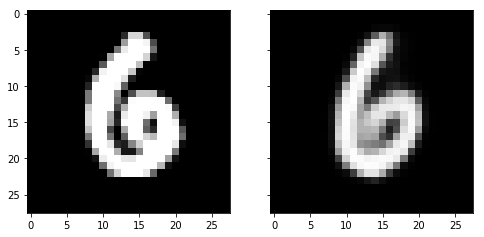

25200 27.48785 16.140543 11.347308


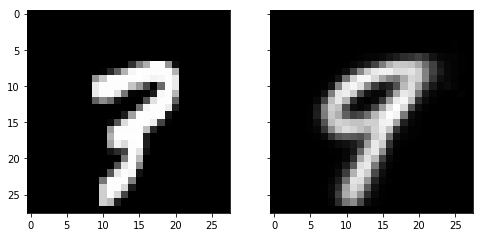

25400 28.317162 17.053492 11.26367


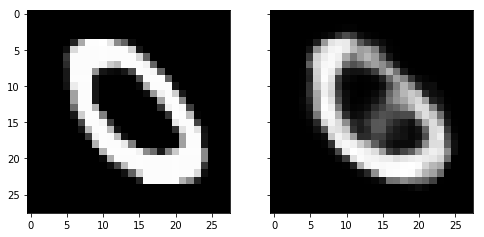

25600 26.091335 15.064732 11.026606


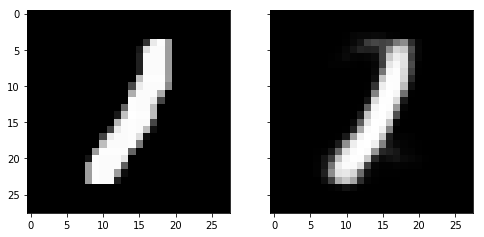

25800 26.725208 16.057264 10.667945


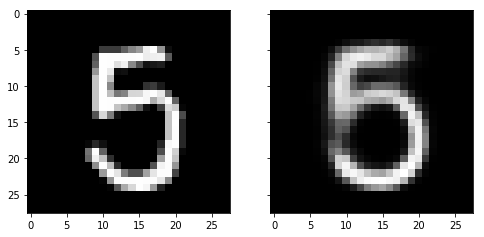

26000 27.346619 16.575394 10.771227


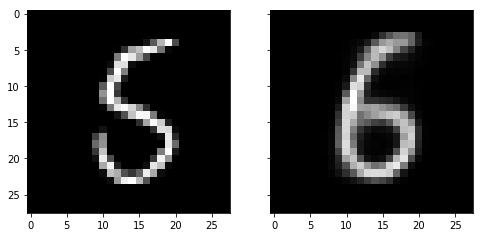

26200 27.76971 16.280636 11.489071


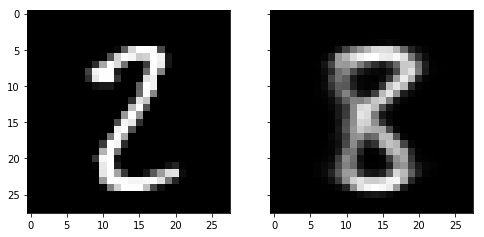

26400 27.015755 16.198814 10.816938


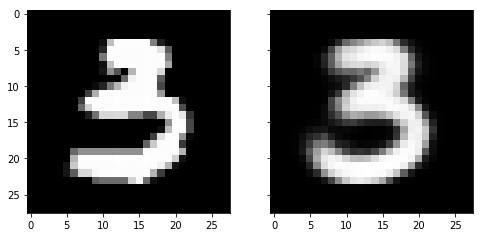

26600 24.855923 14.165308 10.690615


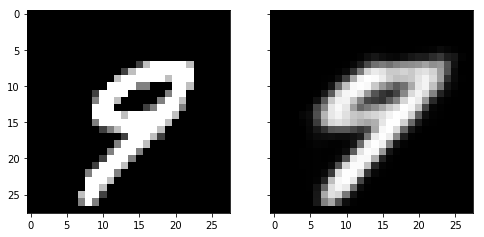

26800 26.174393 15.05798 11.116413


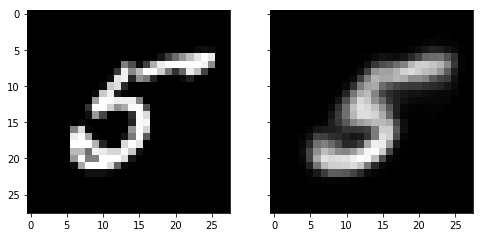

27000 27.834133 16.497906 11.336227


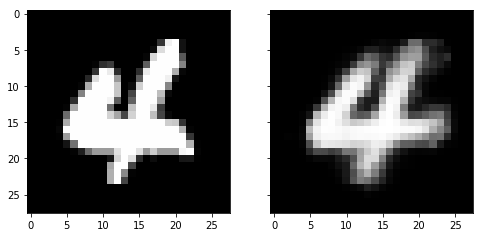

27200 26.115917 14.91849 11.197426


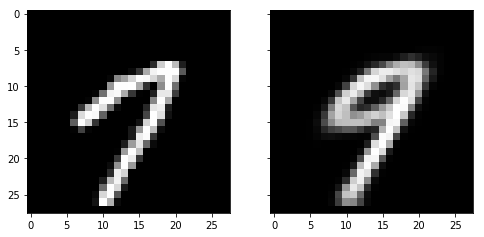

27400 28.237238 17.287731 10.949507


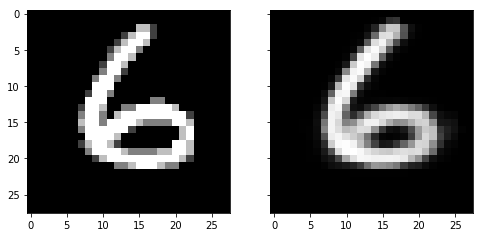

27600 26.382044 15.992198 10.389847


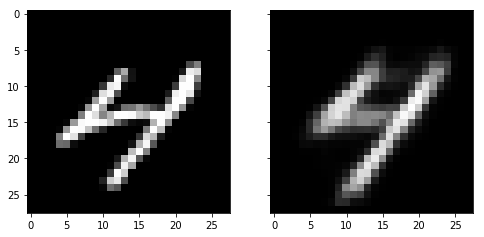

27800 26.984938 15.36422 11.620718


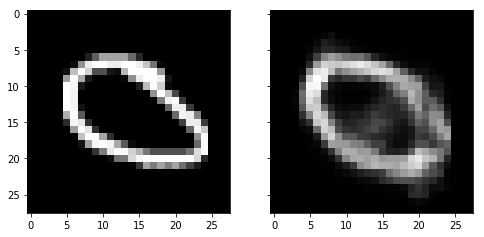

28000 27.652374 16.37312 11.279254


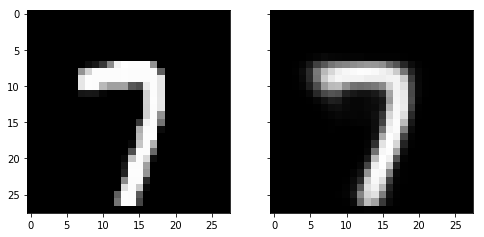

28200 26.219797 15.036958 11.18284


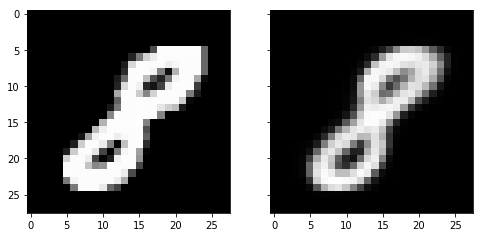

28400 26.89227 15.838327 11.053942


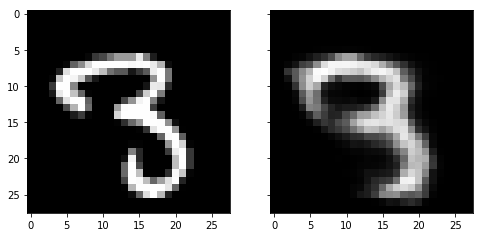

28600 30.115274 18.687263 11.428012


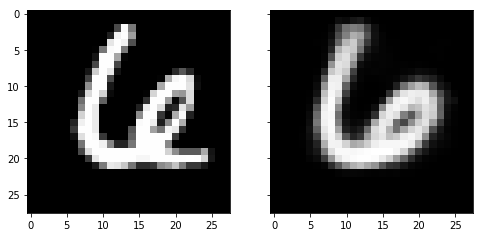

28800 26.505795 15.860695 10.6451


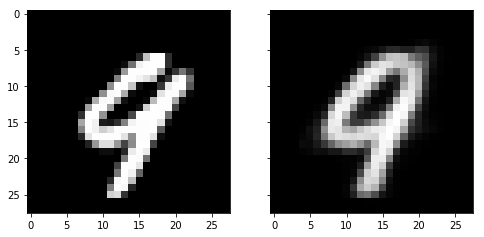

29000 27.30584 16.591232 10.714606


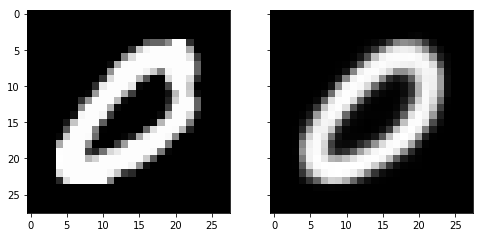

29200 26.828308 16.081293 10.747015


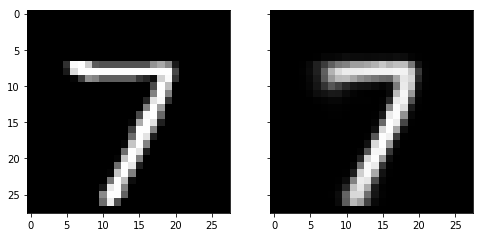

29400 24.841745 14.0944605 10.747285


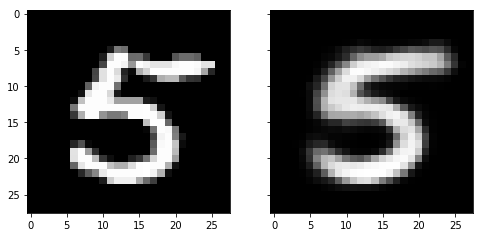

29600 26.10537 15.044298 11.061072


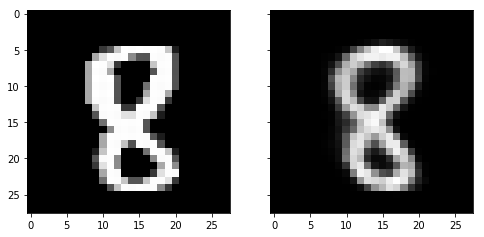

29800 26.903934 16.041464 10.862471


In [11]:
for i in range(30000):
    batch = [np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=batch_size)[0]]
    sess.run(optimizer, feed_dict = {X_in: batch, Y: batch, keep_prob: 0.8})
        
    if not i % 200:
        ls, d, i_ls, d_ls, mu, sigm = sess.run([loss, dec, img_loss, latent_loss, mn, sd], feed_dict = {X_in: batch, Y: batch, keep_prob: 1.0})
        
        fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(8,12))
        
        axes[0].imshow(np.reshape(batch[0], [28, 28]), cmap='gray')
        #plt.show()
        axes[1].imshow(d[0], cmap='gray')
        plt.show()
        print(i, ls, np.mean(i_ls), np.mean(d_ls))

### Generating new data
The most awesome part is that we are now able to create new characters. To this end, we simply sample values from a unit normal distribution and feed them to our decoder. Most of the created characters look just like they've been written by humans.

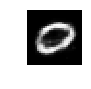

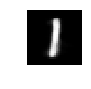

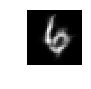

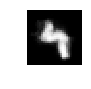

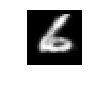

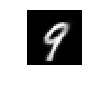

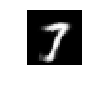

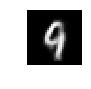

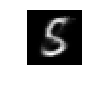

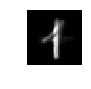

In [12]:
randoms = [np.random.normal(0, 1, n_latent) for _ in range(10)]
imgs = sess.run(dec, feed_dict = {sampled: randoms, keep_prob: 1.0})
imgs = [np.reshape(imgs[i], [28, 28]) for i in range(len(imgs))]

for img in imgs:
    plt.figure(figsize=(1,1))
    plt.axis('off')
    plt.imshow(img, cmap='gray')

### References
* https://jaan.io/what-is-variational-autoencoder-vae-tutorial/
* https://github.com/FelixMohr/Deep-learning-with-Python/blob/master/VAE.ipynb